In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-14 17:38:26.834499: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 17:38:26.864536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:38:26.896773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:38:26.896930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13150056668384311024
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5774573568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15339379007888796273
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/All_cases_100x100_tips.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(41388, 100, 100, 2)

In [5]:
x_train, y_train = [np.expand_dims(train_dataset[:,:,:,0],3),np.expand_dims(train_dataset[:,:,:,1],3)]
x_val, y_val = [np.expand_dims(val_dataset[:,:,:,0],3),np.expand_dims(val_dataset[:,:,:,1],3)]

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (31041, 100, 100, 1), (31041, 100, 100, 1)
Validation Dataset Shapes: (10347, 100, 100, 1), (10347, 100, 100, 1)


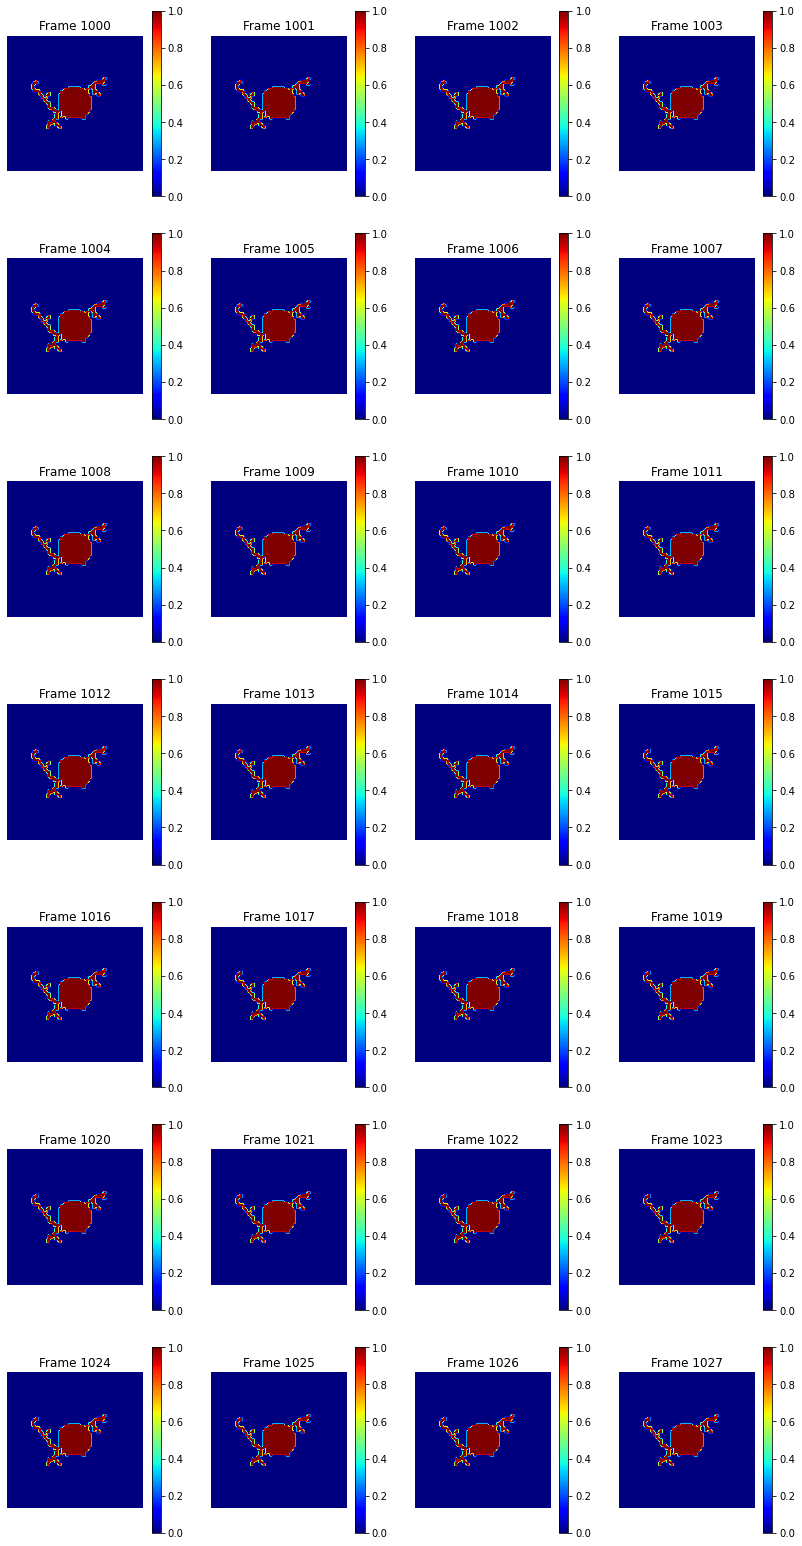

In [6]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(x_train[idx+1000,:,:],cmap='jet')
    plt.title(f"Frame {idx+1000}")
    plt.axis("off")
    plt.colorbar()
plt.show()

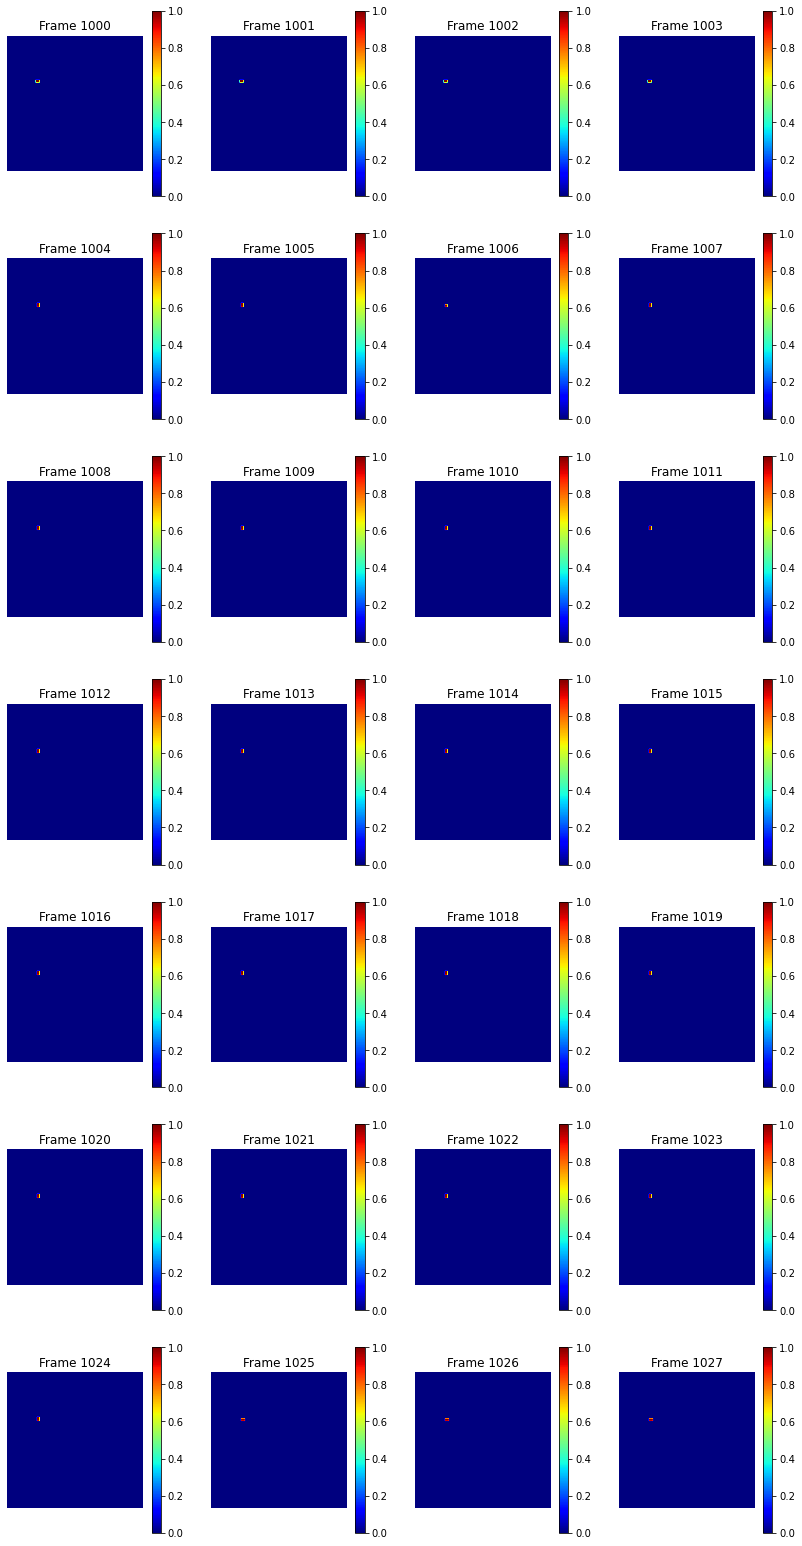

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(y_train[idx+1000,:,:],cmap='jet')
    plt.title(f"Frame {idx+1000}")
    plt.axis("off")
    plt.colorbar()
plt.show()

In [8]:
# inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp = layers.Input(shape=(x_train.shape[1:]))

drop_rate = 0.1
x0 = layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(inp)
x0 = layers.Dropout(drop_rate)(x0)
x0 = layers.BatchNormalization()(x0)
x1 = layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(x0)
x1 = layers.Dropout(drop_rate)(x1)
x1 = layers.BatchNormalization()(x1)
x2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(x1)
x2 = layers.Dropout(drop_rate)(x2)
x2 = layers.BatchNormalization()(x2)
x3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
)(x2)
x3 = layers.Dropout(drop_rate)(x3)
x3 = layers.BatchNormalization()(x3)

2022-06-14 17:41:24.370838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:41:24.371021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:41:24.371128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:41:24.371363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:41:24.371477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [9]:
model = keras.models.Model(inp, x3)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 128)       204928    
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 128)       0         
                                                             

In [10]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_tipsCNN')
else:
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 500
    batch_size = 16

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/model_tipsCNN') 

2022-06-14 17:41:32.994299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241640000 exceeds 10% of free system memory.
2022-06-14 17:41:39.434046: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241640000 exceeds 10% of free system memory.
2022-06-14 17:41:39.911128: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241640000 exceeds 10% of free system memory.
2022-06-14 17:41:40.231034: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241640000 exceeds 10% of free system memory.


Epoch 1/500


2022-06-14 17:41:42.141114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-14 17:41:43.058894: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1941/1941 [==============================] - 22s 10ms/step - loss: 0.9462 - val_loss: 0.1147 - lr: 1.0000e-05
Epoch 2/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.8912 - val_loss: 0.1436 - lr: 1.0000e-05
Epoch 3/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.7412 - val_loss: 0.1678 - lr: 1.0000e-05
Epoch 4/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.2493 - val_loss: 0.0385 - lr: 1.0000e-05
Epoch 5/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.0562 - val_loss: 0.0132 - lr: 1.0000e-05
Epoch 6/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.0198 - val_loss: 0.0075 - lr: 1.0000e-05
Epoch 7/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.0094 - val_loss: 0.0046 - lr: 1.0000e-05
Epoch 8/500
1941/1941 [==============================] - 15s 8ms/step - loss: 0.0058 - val_loss: 0.0037 - lr: 1.0000e-05
Epoch 9/500
1941/1941 [====================

2022-06-14 18:14:19.431662: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/model_tipsCNN/assets


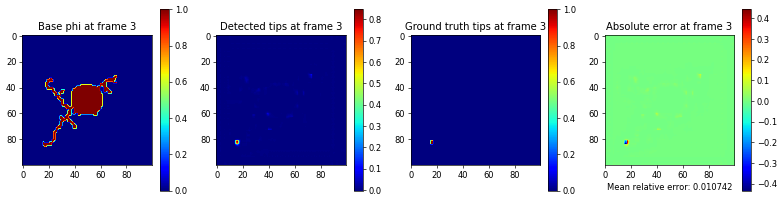

In [26]:
rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]

x_in = np.expand_dims(example_x,axis=0)

tips = model.predict(x_in)

mre = np.sqrt(np.sum(np.square(tips[0,:,:,0]-example_y[:,:,0])/(tips.shape[1]*tips.shape[2])))

plt.figure(figsize=(16, 4), dpi=60)

plt.subplot(1,4,1)
plt.imshow(example_x[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Base phi at frame %d'%(i+3))

plt.subplot(1,4,2)
plt.imshow(tips[0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('Detected tips at frame %d'%(i+3))

plt.subplot(1,4,3)
plt.imshow(example_y[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Ground truth tips at frame %d'%(i+3))

plt.subplot(1,4,4)
plt.imshow(tips[0,:,:,0]-example_y[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Absolute error at frame %d'%(i+3))
plt.xlabel('Mean relative error: %f'%mre)

plt.show()

In [27]:
from tqdm import tqdm

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]

    x_in = np.expand_dims(example_x,axis=0)

    tips = model.predict(x_in)

    mre.append(np.sqrt(np.sum(np.square(tips[0,:,:,0]-example_y[:,:,0])/(tips.shape[1]*tips.shape[2]))))

print(sum(mre) / len(mre))

Running ...: 100%|██████████| 10347/10347 [04:28<00:00, 38.51it/s]

0.027190938978985196
